<a href="https://colab.research.google.com/github/NYUExperimentalPhysics1-2021/lecture-notes/blob/main/Lecture_magnetic_field_curve_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
#@title $\gets$ Run Me First (I have the code setup and function definitions)


import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from bisect import bisect_left, bisect_right
import os, glob
import itertools,operator
from timeit import default_timer as timer
from enum import Enum
import json

gaccel = 9.802

MAJAXIS = 0
MINAXIS = 1
THETA = 2
DPHI = 3
MAGROT = 4
MAGROTRATE =5



class emptystruct:
  pass

def findAngleFiles (startdir):
  #(angleFiles,magFiles) = findSlopeAndAmplitudeFiles(startdir)
  # input stardir: path to directory containing experiments
  # output: list of paths to angle files
  # output slopeFiles: dictionary with paths to slope files, key names are taken from directories under large bob
  #   e.g. if large bob has a directory 2mm, then
  #   slopeFiles["2mm"] is a list of paths to all slope files (end _slope.txt) 
  #   under this directory, even in subdirectories
  # output amplitudeFiles: same as slopeFiles, but paths to all files ending _angle.txt
  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python
  
    return sorted(glob.glob(startdir + '/**/*_angle.txt'))
def rreplace(s, old, new, occurrence):
  #replace last instance https://stackoverflow.com/questions/2556108/rreplace-how-to-replace-the-last-occurrence-of-an-expression-in-a-string/59082116#59082116
  li = s.rsplit(old, occurrence)
  return new.join(li)

# needed to check data validity
# returns the indices of the first and last element of the largest sequence of true in a list of booleans
def longestTrueSequence(seq):
  #adapted from https://stackoverflow.com/questions/40166522/find-longest-sequence-of-0s-in-the-integer-list
  r = max((list(y) for (x,y) in itertools.groupby((enumerate(seq)),operator.itemgetter(1)) if x), key=len)
  return (r[0][0], r[-1][0])

# Checking data validity (no missed swings, dt reasonable)
# returns longest sequence of valid data
def timeCheck(time,number):
  dt = np.diff(time)
  dn = np.diff(number)%256 #number is mod 256
  maxperiod = 5 #equivalent to 6 meter pendulum
  valid = (dt > 0) & (dt < maxperiod) & (dn==2)
  (start,stop) = longestTrueSequence(valid)
  return (start,stop)
  

def loadAndParseData (angleFilePath, z0=1, scale=None, max_rows=450000): #450k readings = 1500s
  magFilePath = rreplace(angleFilePath, 'angle', 'mag',1)
  tcross, theta, majaxis, minaxis, number = np.loadtxt(angleFilePath, skiprows = 1, unpack = True)
  (start,stop) = timeCheck(tcross, number)
  tcross = tcross[start:stop+1]
  theta = theta[start:stop+1]
  majaxis = majaxis[start:stop+1]
  minaxis = minaxis[start:stop+1]
  period = np.mean(np.diff(tcross))

  fixedParams = emptystruct()
  fixedParams.z0 = z0
  fixedParams.L = gaccel*(0.5*period/np.pi)**2

  experiment = emptystruct()
  experiment.anglePath = angleFilePath
  experiment.magPath = magFilePath
  experiment.period = period
  experiment.skip = 1
  

  xinit = []
  experiment.phi = []
  experiment.b = []


  tmag, magX, magY, magZ = np.loadtxt(magFilePath, skiprows = 1, unpack = True, max_rows=max_rows)

  b0 = []

  if scale is None:
    scale = z0

  for i in range(len(tcross)-1):
    if (majaxis[i]) < 0:
      majaxis[i] = -majaxis[i]
      minaxis[i] = -minaxis[i]
    start = bisect_left(tmag, tcross[i])
    stop = bisect_right(tmag, tcross[i+1])
    if (stop>=len(tmag)):
      break    
    xinit.append((majaxis[i]*scale, minaxis[i]*scale, np.mod(np.deg2rad(theta[i]), 2*np.pi), 0, 0, 0)) #a, b, theta, dphi, tiltrot0, tiltrotrate
    experiment.phi.append(2*np.pi*(tmag[start:stop] - tcross[i]) / (tcross[i+1]-tcross[i]) )
    experiment.b.append((magX[start:stop], magY[start:stop], magZ[start:stop]))
    b0.append(np.sign(magZ[start])*np.max(np.sqrt(magZ[start:stop]**2 + magX[start:stop]**2 + magY[start:stop]**2)))

  experiment.tcross = tcross[0:len(experiment.phi)]

  fixedParams.B0 = np.mean(b0)
  experiment.fixedParams = fixedParams
  experiment.offsetInit = (0.0,0.0)
  experiment.tiltAngleInit = 0.0
  experiment.orbitParametersInit = np.array(xinit)

  experiment.orbitParameters = np.copy(experiment.orbitParametersInit)
  experiment.offset = (0.0,0.0)
  experiment.tiltAngle = 0.0

  experiment.axisWeight = [1.0,1.0,1.0]

  alignTheta(experiment)
  calculateB0(experiment)

  plt.figure()

  experiment.fitCompleted = False

  return experiment

def calculateB0(experiment):
  result = scipy.optimize.minimize(lambda x : bscaleObjective(x, experiment), 1, bounds=[(0.1, 10)],options={"maxiter":1000,"disp":False})
  experiment.fixedParams.B0 = experiment.fixedParams.B0*result.x[0]

def bscaleObjective(x, experiment):
  sqerr = 0
  for i in range(len(experiment.phi)):
    bf = bfieldOneOrbit([],experiment,i,[])*x
    deltabs = (bf - np.asarray(experiment.b[i])[:,::experiment.skip])**2
    for j in range(3):
      sqerr = sqerr + np.sum(deltabs[j,:]*experiment.axisWeight[j])
  return sqerr

def rmsError(experiment):
  skip = experiment.skip
  experiment.skip = 1
  sqerr = bscaleObjective(1,experiment)
  nelem = 0
  for p in experiment.phi:
    nelem = nelem + len(p)
  experiment.skip = skip
  return np.sqrt(sqerr/(3*nelem))

#predicted b, measured b, measured - predicted, sum square error
def bfieldAndResidualFromExperiment(experiment, ind, initial=False):
  if initial:
    orbit = experiment.orbitParametersInit[ind,:]
    bfield = bfieldOneOrbit(orbit, experiment, ind, np.arange(6))
  else:
    bfield = bfieldOneOrbit([], experiment, ind, [])
  be = np.asarray(experiment.b[ind])[:,::experiment.skip]
  res =  be - bfield
  resnorm = np.sum(res**2)
  return (bfield, be, res, resnorm)

def alignTheta(experiment):
  for i in range(len(experiment.phi)):
    b = experiment.b[i]
    ip = np.copy(experiment.orbitParametersInit[i,:])
    bi1 = bfieldOneOrbit(ip, experiment, i, np.arange(6))
    ip[THETA] = np.mod(ip[THETA]+np.pi, 2*np.pi)
    bi2 = bfieldOneOrbit(ip, experiment, i, np.arange(6))
    if (np.sum((bi2-b)**2) < np.sum((bi1-b)**2)):
      experiment.orbitParametersInit[i,THETA] = ip[THETA]

    theta = experiment.orbitParameters[i,THETA]
    b1 = bfieldOneOrbit(theta, experiment, i, THETA)
    b2 = bfieldOneOrbit(theta + np.pi, experiment, i, THETA)
    if (np.sum((b2-b)**2) < np.sum((b1-b)**2)):
      experiment.orbitParameters[i,THETA] = np.mod(theta + np.pi, 2*np.pi)


def dipole_bfield(b0,x,y,dz, z0, tx, ty):
  #field at 0,0,0 if magnet is located at x,y,dz + z0, and tilted from z direction by tx and ty, assuming tx and ty are small 
  #b0 is z-field when magnet is at 0,0,z0 and tx,ty = 0
  #b = u0/4pi r^5 |m|(3 r*(r dot mhat) - r^2 mhat) (wiki magnetic dipole)

  x = x/z0
  y = y/z0
  z = (1 + dz/z0)
  rs = x**2 + y**2 + z**2
  r5 = np.power(rs,2.5)
  mhatz = (1-0.5*tx**2-0.5*ty**2)
  mdotr = -x*tx - y*ty - z*mhatz
  return b0/(2*r5)*(-3*x*mdotr - tx*rs, -3*y*mdotr - ty*rs, -3*z*mdotr - rs*mhatz)

def ellipticalOrbit(phi,a,b,theta,L):
  u = a*np.sin(phi)
  v = -b*np.cos(phi)
  x = u*np.cos(theta) - v*np.sin(theta)
  y = u*np.sin(theta) + v*np.cos(theta)
  dz = L - np.sqrt(L**2 - u**2 - v**2)
  tx = -x/L
  ty = -y/L
  return(x,y,dz,tx,ty)

def ellipticalMagField(phi, a, b, theta, tiltRot0, tiltRotRate, dphi, offset, tiltAngle, fixedParams):
  mp = np.mean(phi)
  tiltx = tiltAngle*np.cos(tiltRot0 + tiltRotRate*(phi-mp))
  tilty = tiltAngle*np.sin(tiltRot0 + tiltRotRate*(phi-mp))
  (x,y,dz,tx,ty) = ellipticalOrbit(phi + dphi,a,b,theta, fixedParams.L)
  return dipole_bfield(fixedParams.B0, x + offset[0], y + offset[1], dz, fixedParams.z0, tx + tiltx, ty + tilty)


def extractGlobalParametersFromVec(x):
  return (x[3:], x[0:2], x[2])

def getParametersFromVec(x,nparams=6,offset=None,tiltAngle=None):
  if (offset is None):
    (x, offset, tiltAngle) = extractGlobalParametersFromVec(x)
  if nparams > 0:
    orbit = np.reshape(x,(-1,nparams))
  else:
    orbit = []
  return(offset, tiltAngle, orbit)
 
def getParametersFromOrbit(orbit):
  #a, b, theta, dphi, tiltrot0, tiltrotrate
  orbit = np.atleast_2d(orbit)
  a = orbit[:,0]
  b = orbit[:,1]
  theta = orbit[:,2]
  dphi = orbit[:,3]
  if np.shape(orbit)[1] >= 5:
    tiltRot0 = orbit[:,4]
  else:
    tiltRot0 = 0.0*a
  if np.shape(orbit)[1] >= 6:
    tiltRotRate = orbit[:,5]
  else:
    tiltRotRate = 0.0*a
  return (a, b ,theta, dphi, tiltRot0, tiltRotRate)

def getVectorFromParameters(offset, tiltAngle, orbit):
  gv = np.full(3,tiltAngle, 'float64')
  gv[0:2] = offset
  return np.concatenate((gv,np.ravel(orbit)))


def bfieldFromParamVecAndExperiment(x, experiment,inds,paraminds,offset=None,tiltAngle=None,fitspin=False):
  if inds is None:
    inds = np.arange(len(experiment.phi))
  if paraminds is None:
    paraminds = np.arange(6)
  
  (offset, tiltAngle, orbitParams) = getParametersFromVec(x,len(paraminds),offset,tiltAngle)
  orbit = experiment.orbitParameters[inds,:]
  orbit[:,paraminds] = orbitParams
  (a, b ,theta, dphi, tiltRot0, tiltRotRate) = getParametersFromOrbit(orbit)
  bfield = []
  for i in range(len(a)):
    #ellipticalMagField(phi, a, b, theta, tiltRot0, tiltRotRate, dphi, offset, tiltAngle, fixedParams):
    bfield.append(ellipticalMagField(np.asarray(experiment.phi[inds[i]])[0::experiment.skip], a[i], b[i], theta[i], tiltRot0[i], tiltRotRate[i], dphi[i], offset, tiltAngle, experiment.fixedParams))
  return bfield



def bfieldOneOrbit(orbitParams, experiment, index, paraminds):
  orbit = np.copy(experiment.orbitParameters[index,:])
  orbit[paraminds] = orbitParams
  (a, b ,theta, dphi, tiltRot0, tiltRotRate) = getParametersFromOrbit(orbit)
  return ellipticalMagField(np.asarray(experiment.phi[index])[0::experiment.skip], a, b, theta, tiltRot0, tiltRotRate, dphi, experiment.offset, experiment.tiltAngle, experiment.fixedParams)

def bfieldOneOrbitTiltAdj(experiment, index, tiltAngle, tiltRotation, tiltRotRate):
  (a, b ,theta, dphi, *_) = getParametersFromOrbit(experiment.orbitParameters[index,:])
  return ellipticalMagField(np.asarray(experiment.phi[index])[0::experiment.skip], a, b, theta, tiltRotation, tiltRotRate, dphi, experiment.offset, tiltAngle, experiment.fixedParams)


def fitterObjectiveTiltOrbit(x, experiment, index):
  tiltAngle = x[0]
  tiltRotation = x[1]
  if (len(x)>=3):
    tiltRotRate = x[2]
  else:
    tiltRotRate = 0
  
  bfield = bfieldOneOrbitTiltAdj(experiment, index, tiltAngle, tiltRotation, tiltRotRate)
  deltabs = (bfield - np.asarray(experiment.b[index])[:,::experiment.skip])**2
  sqerr = 0
  for j in range(3):
    sqerr = sqerr + np.sum(deltabs[j,:]*experiment.axisWeight[j])
  return sqerr



def fitterObjectiveOrbit(x,experiment,index, paraminds):
  bfield = bfieldOneOrbit(x, experiment, index, paraminds)
  deltabs = (bfield - np.asarray(experiment.b[index])[:,::experiment.skip])**2
  sqerr = 0
  for j in range(3):
    sqerr = sqerr + np.sum(deltabs[j,:]*experiment.axisWeight[j])
  return sqerr

def fitterObjectiveFunction (x, experiment, inds, paraminds):
  bfield = bfieldFromParamVecAndExperiment (x, experiment, inds, paraminds)
  sqerr = 0
  for i in range(len(bfield)): 
    deltabs = (bfield[i] - np.asarray(experiment.b[inds[i]])[:,::experiment.skip])**2
    for j in range(3):
      sqerr = sqerr + np.sum(deltabs[j,:]*experiment.axisWeight[j])
  return sqerr



def getBounds(xinit, paraminds):
  
  offsetmin = (-0.01,-0.01)
  offsetmax = (0.01,0.01)
  tiltAngleMin = 0
  tiltAngleMax = np.deg2rad(10)

  (offset, tilt, orbit) = getParametersFromVec(xinit,len(paraminds))

  upper = (0.3, 0.1, 2*np.pi+0.1, 0.1, 2*np.pi+0.1, 2)
  lower = (0, -0.1, -0.1, -0.1, -0.1, -2)
  if np.size(orbit) == 0:
    minp = []
    maxp = [] 
  else:
    maxp = orbit*0.0
    minp = orbit*0.0
    for i in range(len(paraminds)):
      maxp[:,i] = upper[paraminds[i]]
      minp[:,i] = lower[paraminds[i]]


  lb = getVectorFromParameters(offsetmin, tiltAngleMin, minp)
  ub = getVectorFromParameters(offsetmax, tiltAngleMax, maxp)
  return np.transpose((lb,ub))

def fitGlobal(experiment, inds=None, paraminds=[]):

  paraminds = np.atleast_1d(paraminds)
  if (np.size(paraminds) == 0):
    paraminds = []
  if inds is None:
    inds = np.arange(len(experiment.phi))
  xinit = getVectorFromParameters(experiment.offset, experiment.tiltAngle, experiment.orbitParameters[np.ix_(inds,paraminds)])
  bounds = getBounds(xinit,paraminds)
  
  result = scipy.optimize.minimize(lambda x : fitterObjectiveFunction(x, experiment, inds, paraminds), xinit, bounds=bounds,options={"maxiter":1000,"disp":False})
  (experiment.offset, experiment.tiltAngle, orbit) = getParametersFromVec(result.x, len(paraminds))
  experiment.orbitParameters[np.ix_(inds,paraminds)] = orbit
  return result


def fitOrbits(experiment, paraminds=np.arange(6), inds=None):

  paraminds = np.atleast_1d(paraminds)
  xinit = getVectorFromParameters((0,0),0, np.zeros(len(paraminds)))
  bounds = getBounds(xinit, paraminds)
  bounds = bounds[3:,:]

  rv = []
  if inds is None:
    inds = range(len(experiment.phi))
  for i in inds:
    xinit = experiment.orbitParameters[i,paraminds]
    result = scipy.optimize.minimize(lambda x : fitterObjectiveOrbit(x,experiment,i,paraminds), xinit, bounds = bounds, options={"maxiter":1000,"disp":False})
    experiment.orbitParameters[i, paraminds] = result.x   
    rv.append(result)
  #a, b, theta, dphi, tiltrot0, tiltrotrate
  experiment.orbitParameters[:,2] = np.mod(experiment.orbitParameters[:,2],2*np.pi)
  experiment.orbitParameters[:,4] = np.mod(experiment.orbitParameters[:,4],2*np.pi)
  
  return rv



def fitExperiment(experiment):
  if experiment.fitCompleted:
    return
  plt.figure()
  (a, b ,theta,dphi,r,rr) = getParametersFromOrbit(experiment.orbitParameters)
  plt.plot(experiment.tcross, np.unwrap(theta)*180/np.pi)
  start = timer()
  sk = experiment.skip
  aw = experiment.axisWeight
  experiment.orbitParameters[:,MAGROTRATE] = 0
  experiment.skip = 8
  experiment.axisWeight = (1,1,1)
  experiment.tiltAngle = np.deg2rad(3)
  fitOrbits(experiment, (MAGROT))
  fitGlobal(experiment)

  print("B0 initial: {:2f}".format(experiment.fixedParams.B0))
  calculateB0(experiment)
  print("B0 updated: {:2f}".format(experiment.fixedParams.B0))
  

  fitOrbits(experiment, (THETA, MAGROT))

  fitGlobal(experiment)
  
  print('{:2f} s elapsed; initial fit - offset = {} ; tilt = {}'.format(timer()-start, experiment.offset*1000, experiment.tiltAngle*180/np.pi))

  fitOrbits(experiment, (MAJAXIS, MINAXIS, THETA, DPHI))
  fitGlobal(experiment)

  fitOrbits(experiment, (THETA, MAGROT))  

  fitGlobal(experiment)

  calculateB0(experiment)
  print("B0 updated: {:2f}".format(experiment.fixedParams.B0))
  fitOrbits(experiment, (MAJAXIS, MINAXIS, THETA, DPHI))
  fitGlobal(experiment)

  
  
  print('{:2f} s elapsed; refit orbit dimensions - offset = {} ; tilt = {}'.format(timer()-start, experiment.offset*1000, experiment.tiltAngle*180/np.pi))

  tilt = experiment.tiltAngle
  for reps in range(10):
    fitOrbits(experiment, (THETA, MAGROT))  
    fitGlobal(experiment)
    dtilt = experiment.tiltAngle-tilt
    if (np.abs(dtilt) < np.deg2rad(0.1)):
      break
    tilt = experiment.tiltAngle
  
  print('{:2f} s elapsed; iterated fitter completed with dtilt = {} - offset = {} ; tilt = {}'.format(timer()-start, dtilt*180/np.pi, experiment.offset*1000, experiment.tiltAngle*180/np.pi))


    

  # experiment.axisWeight = (1,1,1)
  # inds = np.arange(0,len(experiment.phi),np.ceil(len(experiment.phi)/16),dtype=int) #15 evenly spaced
  # paraminds = (THETA, MAGROT)
  # fitGlobal(experiment, inds, paraminds)
  # print('{:2f} s elapsed; fit offset and tilt with orbit adjustments - offset = {} ; tilt = {}'.format(timer()-start, experiment.offset*1000, experiment.tiltAngle*180/np.pi))
  (a, b ,theta,dphi,r,rr) = getParametersFromOrbit(experiment.orbitParameters)
  plt.plot(experiment.tcross, np.unwrap(theta)*180/np.pi)

  for reps in range(10):
    fitOrbits(experiment, (THETA, MAGROT, MAGROTRATE))  
    fitGlobal(experiment)
    dtilt = experiment.tiltAngle-tilt
    if (np.abs(dtilt) < np.deg2rad(0.05)):
      break
    tilt = experiment.tiltAngle

  fitOrbits(experiment, (THETA, MAGROT, MAGROTRATE))
  print('{:2f} s elapsed; iterated fitter with spin completed with dtilt = {} - offset = {} ; tilt = {}'.format(timer()-start, dtilt*180/np.pi, experiment.offset*1000, experiment.tiltAngle*180/np.pi))

  # experiment.axisWeight = (1,1,0)
  # fitOrbits(experiment, (THETA, MAGROT, MAGROTRATE))

  # fitGlobal(experiment)
  # fitOrbits(experiment, (THETA, MAGROT, MAGROTRATE))

  # print('{:2f} s elapsed; added in spin - offset = {} ; tilt = {}'.format(timer()-start, experiment.offset*1000, experiment.tiltAngle*180/np.pi))
  (a, b ,theta,dphi,r,rr) = getParametersFromOrbit(experiment.orbitParameters)
  plt.plot(experiment.tcross, np.unwrap(theta)*180/np.pi)
  plt.legend(('initial','without spin', 'with spin'))
  plt.xlabel('time')
  plt.ylabel('maj axis angle')
  experiment.fitCompleted = True

def updateExperiments(startdir, experiments):
  plt.rcParams['figure.figsize'] = [8, 5]
  angleFiles = findAngleFiles(startdir)
  for file in angleFiles:
    found = False
    for e in experiments:
      if os.path.normpath(file) == os.path.normpath(e.anglePath):
        found = True
    if not(found):
      print('loading and fitting: {}'.format(file))
      e = loadAndParseData(file, z0)
      fitExperiment(e)
      experiments.append(e)
      print('{}/{} experiments fit'.format(len(experiments), len(angleFiles)))
      plt.show()

def plotRotationRateExperiments (experiments, delta = 100):
  plt.rcParams['figure.figsize'] = [12, 8]
  deghr = np.rad2deg(1)*3600
  rotf = -15/deghr*np.sin(np.deg2rad(40.730610))
  
  ratio = []
  rate = []

  for e in experiments:
    (a, b ,theta,dphi,r,rr) = getParametersFromOrbit(e.orbitParameters)
    t = e.tcross
    numpts = int(np.ceil((t[-1]-t[0])/delta))
    inds = np.linspace(0,len(t),numpts, endpoint=False, dtype=int)
    ratio.append(np.diff(np.cumsum(a*b)[inds])/np.diff(inds)*np.pi/((e.fixedParams.L**2) * experiments[0].period))
    rate.append(np.diff(np.unwrap(theta)[inds])/np.diff(t[inds]))

  for i in range(len(ratio)):
    plt.plot(ratio[i]*1e6, rate[i]*1e6, marker='.', linestyle='none')

  slopepred = .75
  ratio_axis = np.linspace(np.min(np.concatenate(ratio)), np.max(np.concatenate(ratio)))

  ratepred =  slopepred*ratio_axis
  plt.plot(1e6*ratio_axis, 1e6*(ratepred+rotf), 'k-', label='predicted')
  plt.ylabel(r'precession rate ($\mu$rad/s)', fontsize=20)
  plt.xlabel(r'$\frac{\pi a b}{L^2 T}$ ($\mu$rad/s)', fontsize=20)  

  p = np.polyfit(np.concatenate(ratio), np.concatenate(rate), 1)
  plt.plot(1e6*ratio_axis,1e6*(ratio_axis*p[0] + p[1]), 'm--', label='fit')
  plt.legend()
  print('slope measured, predicted = {:2f},{:2f}'.format(p[0], slopepred))
  print('intercept measured, predicted = {:2f},{:2f} deg/hr'.format(p[1]*deghr, rotf*deghr))

z0 = .054321 #enter the calibration height above magentometer for your experiments in METERS (i.e. if 60 mm, enter .060)
!git clone https://github.com/NYUExperimentalPhysics1-2021/lab4-individual-data-mgershow data #change to your github user name - do not erase the "data" afterwards
startdir = '/content/data'
experiments = []
angleFiles = findAngleFiles(startdir)
experiment = loadAndParseData(angleFiles[0], 0.0535)

fatal: destination path 'data' already exists and is not an empty directory.


<Figure size 864x576 with 0 Axes>

#Formula for magnetic field of a dipole

If a magnet with a dipole moment $\vec{m}$ is located at the origin, and you measure the field at a point $\vec{r}$

$\vec{B}(\vec{r}) = (B_x, B_y, B_z) = \frac{\mu_0}{4 \pi r^5}\left(3 \vec{r}(\vec{m}\cdot \vec{r}) - \vec{m} r^2\right)$



Let's write $\vec{m} = M \hat{m}$, where $\hat{m}$ is the direction the magnet points. 

Now let's write down the field when $\vec{r} = (0, 0, \pm z_0)$ and $\hat{m} = \hat{z} = (0, 0, 1)$

In this case, $B_x = B_y = 0$ and $B_z = M \frac{\mu_0}{4 \pi z_0^5}(3z_0*z_0 - z_0^2) = \frac{\mu_0}{4 \pi}\frac{2}{z_0^3}$

Let's call this field $B_0$; then $M \frac{\mu_0}{4 \pi} = \frac{z_0^3}{2}{B_0}$

We can now divide everything by $z_0$ to find

$\vec{B}(\frac{\vec{r}}{z_0})$ = $\frac{B_0}{2}\frac{\left(3 \frac{\vec{r}}{z_0}(\frac{\vec{r}}{z_0}\cdot\hat{m}) - \hat{m}\frac{r^2}{z_0^2}\right)}{(r/z_0)^5}$

That's a bit of a mess, so let's just use units of $z_0$ and ignore the fractions: i.e. $x \to \frac{x}{z_0}, y \to \frac{z}{z_0}, z \to \frac{z}{z_0}$

Then

$\vec{B}(\vec{r})$ = $\frac{B_0}{2 r^5}\left(3 \vec{r}(\vec{r}\cdot\hat{m}) - \hat{m}{r^2}\right)$

Finally, let's assume that $\hat{m}$ is mainly in the $\hat{z}$ direction (the magnet pointing in the (0,0,-1) direction is taken care of by making $M$ and hence $B_0$ negative). 

$\hat{m} = (t_x, t_y, 1 - \frac{1}{2} (t_x^2 + t_y^2))$

Then the formula for the field at $(x,y,z)$ (remember these are really $\frac{x}{z_0}, \frac{y}{z_0}, \frac{z}{z_0}$) is ...

$\vec{r}\cdot\hat{m} = (t_x x + t_y y + (1- \frac{1}{2}(t_x^2 + t_y^2)) z)$

$B_x = \frac{B_0}{2 r^5} (3 x (\vec{r}\cdot\hat{m}) - t_x r^2)$

$B_y = \frac{B_0}{2 r^5} (3 y (\vec{r}\cdot\hat{m}) - t_y r^2)$

$B_z = \frac{B_0}{2 r^5} (3 z (\vec{r}\cdot\hat{m}) - (1 - \frac{1}{2} (t_x^2 + t_y^2))r^2)$

Note that although this formula is for the magnet at $\vec{0}$ and the measurement at $\vec{r}$, you get the same result if you measure at $\vec{0}$ and move the magnet to $\vec{r}$, because the formula is symmetric if you change $\vec{r} \to -\vec{r}$

In [2]:
def dipole_bfield(b0,x,y,dz, z0, tx, ty):
  #field at 0,0,0 if magnet is located at x,y,dz + z0, and tilted from z direction by tx and ty, assuming tx and ty are small 
  #b0 is z-field when magnet is at 0,0,z0 and tx,ty = 0
  #b = u0/4pi r^5 |m|(3 r*(r dot mhat) - r^2 mhat) (wiki magnetic dipole)

  x = x/z0
  y = y/z0
  z = (1 + dz/z0)
  rs = x**2 + y**2 + z**2
  r5 = np.power(rs,2.5)
  mhatz = (1-0.5*tx**2-0.5*ty**2)
  mdotr = x*tx + y*ty + z*mhatz
  return b0/(2*r5)*(3*x*mdotr - tx*rs, 3*y*mdotr - ty*rs, 3*z*mdotr - rs*mhatz)

#Motion in an elliptical orbit

The parametric formula for an elliptical orbit with the major axis aligned along the x-axis  is $(x,y) = (a \sin(\phi), -b \cos(\phi))$, where $\phi = \omega t$. 

If you rotate the ellipse so that its major axis axis is inclined from the x-axis by $\theta$, then 

$x' = x \cos(\theta) - y \sin(\theta)$

$y' = x \sin(\theta) + y \cos(\theta)$

If the orbiting object is a bob on a string of length $L$, then moving the bob both lifts and tilts it. 

$\Delta z = L - \sqrt{L^2 - (x^2 + y^2)}$

$t_x = -\frac{x'}{L}$

$t_y = -\frac{y'}{L}$



In [3]:
def ellipticalOrbit(phi,a,b,theta,L):
  u = a*np.sin(phi)
  v = -b*np.cos(phi)
  x = u*np.cos(theta) - v*np.sin(theta)
  y = u*np.sin(theta) + v*np.cos(theta)
  dz = L - np.sqrt(L**2 - u**2 - v**2)
  tx = -x/L
  ty = -y/L
  return(x,y,dz,tx,ty)

Text(0, 0.5, '$\\hat{m}\\cdot{\\hat{z}}$')

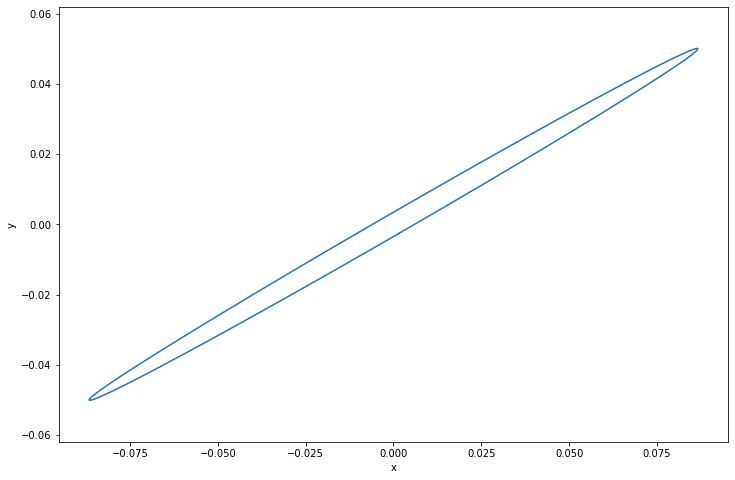

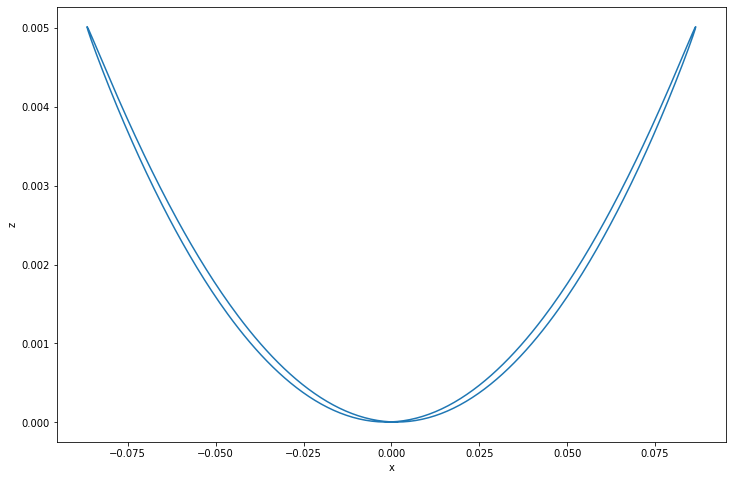

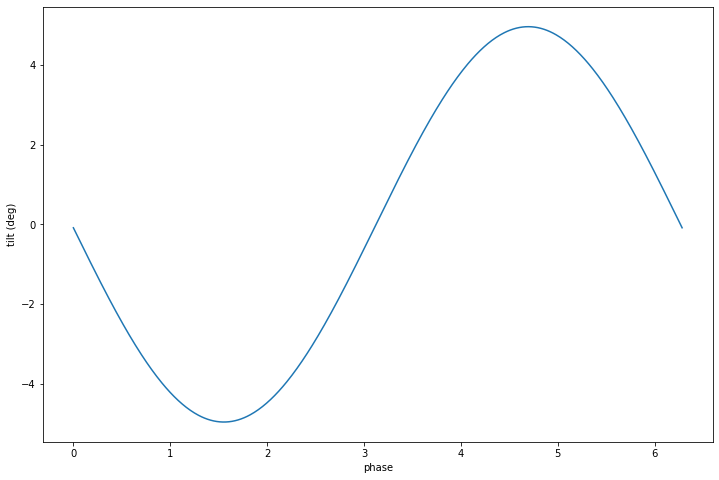

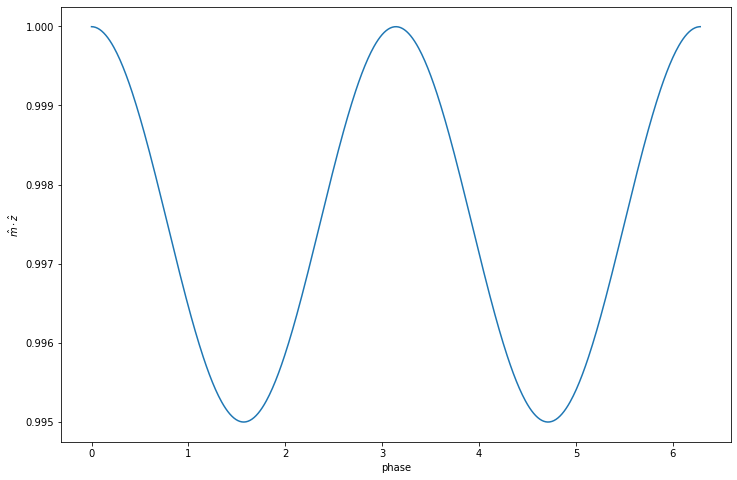

In [17]:
plt.rcParams['figure.figsize'] = [12, 8]

phi = np.linspace(0, 2*(np.pi), 600)
a = .1
b = 0.003
theta = np.deg2rad(30)
L = 1
(x,y,dz,tx,ty) = ellipticalOrbit(phi, a, b, theta, L)
ax = plt.axes()
plt.plot(x,y)
ax.axis('equal');
plt.xlabel('x')
plt.ylabel('y')
plt.figure()
ax = plt.axes()
plt.plot(x,dz)
#ax.axis('equal');
plt.xlabel('x')
plt.ylabel('z')

plt.figure()

plt.plot(phi, np.rad2deg(tx))
plt.xlabel('phase')
plt.ylabel('tilt (deg)')

plt.figure()

plt.plot(phi, 1-0.5*(tx**2 + ty**2))
plt.xlabel('phase')
plt.ylabel(r'$\hat{m}\cdot{\hat{z}}$')

#Simulating the magnetic field from an elliptical orbiting bob

If there's a magnet on the bottom of the bob, we can now calculate the magnetic field at our sensor as the bob moves in an orbit. There are a few other things we should take into account
1. We might not have gotten the exact time the bob crossed the center, so $\phi$ might be a little off by $\Delta \phi$ 
1. The magnet sensor might not be located exactly at $(0,0,0)$, but might instead be at $(\Delta x, \Delta y, 0)$
1. The magnet might have been put on the bob crooked, and might be tilted a little bit even when it's not swinging.

This last point can be explored a little further. If the magnet is put on crooked, it should always be tilted some amount $|t|$ from the $z$-axis. But it could rotate around the axis, potentially even while it's swinging.  

Let's call the angle of the magnet to the x-axis at the midpoint of the swing $\theta_{rot}$ and let's call the ratio of the rotation rate of the bob to the frequency of the pendulum $\frac{d\theta_{rot}}{d\phi}$ Then

$t_x = |t| \cos(\theta_{rot} + \frac{d\theta_{rot}}{d\phi}(\phi - \bar{\phi}))$

$t_y = |t| \sin(\theta_{rot} + \frac{d\theta_{rot}}{d\phi}(\phi - \bar{\phi}))$


In [5]:
def ellipticalMagField(phi, a, b, theta, tiltRot0, tiltRotRate, dphi, offset, tiltAngle, fixedParams):
  mp = np.mean(phi)
  tiltx = tiltAngle*np.cos(tiltRot0 + tiltRotRate*(phi-mp))
  tilty = tiltAngle*np.sin(tiltRot0 + tiltRotRate*(phi-mp))
  (x,y,dz,tx,ty) = ellipticalOrbit(phi + dphi,a,b,theta, fixedParams.L)
  return dipole_bfield(fixedParams.B0, x + offset[0], y + offset[1], dz, fixedParams.z0, tx + tiltx, ty + tilty)


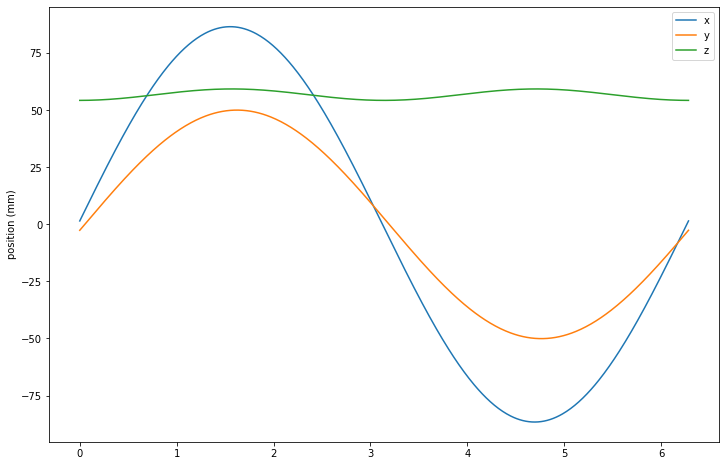

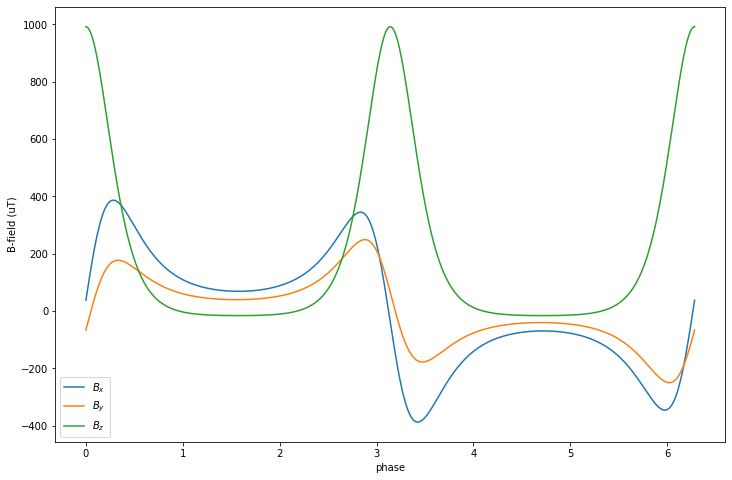

In [18]:
plt.rcParams['figure.figsize'] = [12, 8]

fixedParams = emptystruct() #python gibberish to let me use structure notation instead of dictionary notation
fixedParams.B0 = 1000
fixedParams.z0 = .06
fixedParams.L = L
offset = (0,0)
(bx,by,bz) = ellipticalMagField(phi, a, b, theta, 0, 0, 0, (0,0), 0, fixedParams)
plt.plot(phi, 1000*np.transpose((x,y,z0+dz)))
plt.ylabel('position (mm)')
plt.legend(('x','y','z'))
plt.figure()
plt.plot(phi, np.transpose((bx,by,bz)))
plt.ylabel('B-field (uT)')
plt.xlabel('phase')
plt.legend((r'$B_x$', r'$B_y$', r'$B_z$'));


#Let's look at some real data

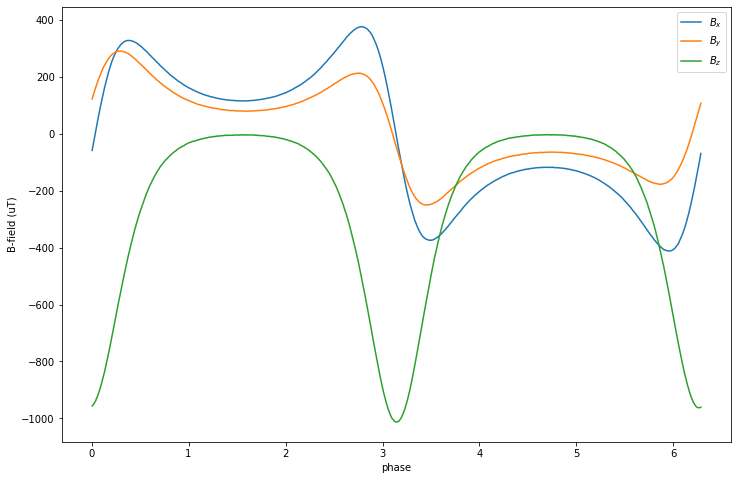

In [19]:
plt.plot(experiment.phi[0], np.transpose(experiment.b[0])) # I loaded the experiment data structure in earlier
plt.ylabel('B-field (uT)')
plt.xlabel('phase')
plt.legend((r'$B_x$', r'$B_y$', r'$B_z$'));

## Can we pick, a, b, theta, dphi, rotation, tilt, offset, etc. to make a b-field prediction that matches the real b-field?

In [11]:
experiment.fixedParams.L

1.9307456319004748

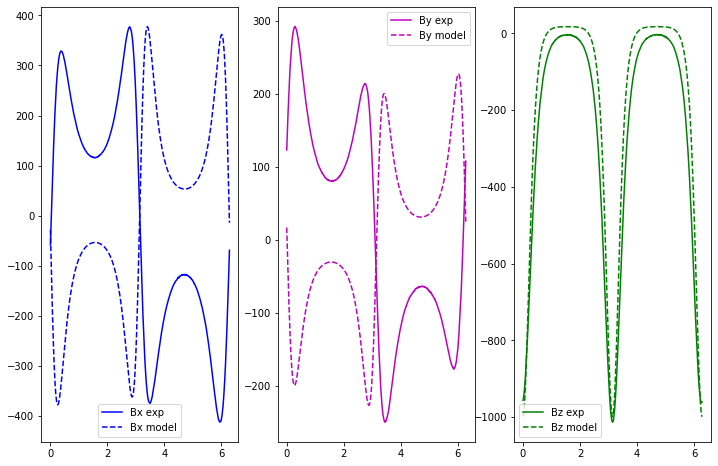

In [36]:
fixedParams.B0 = -1000 #match largest value of z field
fixedParams.z0 = .0535 #from lab book
fixedParams.L = 1.9307 #from period
offset = (0,0)
a = 0.1 #m
b = 0.001
theta = np.deg2rad(30)
(bxe,bye, bze) = experiment.b[0]
phi = experiment.phi[0]
(bx,by,bz) = ellipticalMagField(phi, a, b, theta, 0, 0, 0, offset, 0, fixedParams)
f,ax = plt.subplots(1, 3)

ax[0].plot(phi, bxe, 'b-', label = 'Bx exp')
ax[0].plot(phi, bx, 'b--', label = 'Bx model')
ax[1].plot(phi, bye, 'm-', label = 'By exp')
ax[1].plot(phi, by, 'm--', label = 'By model')
ax[2].plot(phi, bze, 'g-', label = 'Bz exp');
ax[2].plot(phi, bz, 'g--', label = 'Bz model')
ax[0].legend()
ax[1].legend()
ax[2].legend();

# Time for nonlinear curve fitting / least squares minimization

How close is our guess to the true value? Let's minimize the square of the difference

$\sum (\vec{B}_{exp} - \vec{B}_{model})^2$

Steps
1. Define an objective function that calculates this sum for a given set of parameters you'll adjust and data you provide
2. Use `scipy.optimize.minimize` to find the minimum of this function

In [39]:
def oneOrbitObjectiveNoSpin(params, phi, bexp, fixedParams):
  (a, b, theta, tiltRot0, dphi, offsetx, offsety, tiltAngle) = params
  bmodel = ellipticalMagField(phi, a, b, theta, tiltRot0, 0, dphi, (offsetx, offsety), tiltAngle, fixedParams)
  return np.sum((bmodel-bexp)**2)

params = (a,b,theta,0,0,0,0,0)
oneOrbitObjectiveNoSpin(params, experiment.phi[0], experiment.b[0], experiment.fixedParams) #check that it produces an answer

806027697.2858129

Now we need to wrap this all up for the minimizer. The minimizer can take a list of bounds - which we should use

In [40]:
abounds = (0, 0.3) #a between 0 and 30 cm
bbounds = (-.1, .1) #b between -10 and 10 cm
thetabounds = (-0.1, 2*np.pi + 0.1)
tiltRotbounds = (-0.1, 2*np.pi + 0.1)
dphibounds = (-0.1,0.1)
oxbounds = (-0.01, 0.01)
oybounds = (-0.01, 0.01)
tiltbounds = (0, np.deg2rad(15))
mybounds = (abounds, bbounds, thetabounds, tiltRotbounds, dphibounds, oxbounds, oybounds, tiltbounds)

The minimizer wants to minimize a simple function: $f(\vec{x})$ where $\vec{x}$ has the parameters to optimize. There's now room for extra data in this function, so we "wrap" the objective function up in a lambda function

We need an initial guess: I'll use the values that labview came up with, plus some errors so you can see that it works

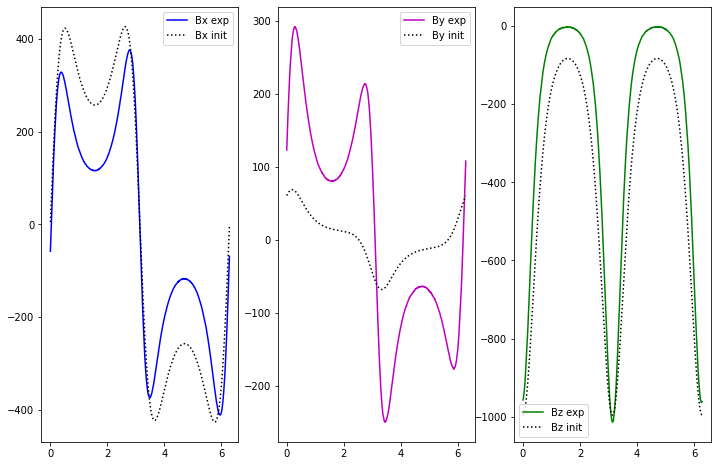

In [61]:
ainit = experiment.orbitParametersInit[0,MAJAXIS] - 0.02
binit = experiment.orbitParametersInit[0,MINAXIS] + 0.001
thetainit = experiment.orbitParametersInit[0,THETA] - .5
dphiinit = 0
tiltrotinit = 0
tiltinit = 0.05 #need to make it not zero so tiltrot can find something
oxinit = 0
oyinit = 0
paramsinit = (ainit, binit, thetainit, tiltrotinit, dphiinit, oxinit, oyinit, tiltinit)

(a, b, theta, tiltRot0, dphi, offsetx, offsety, tiltAngle) = paramsinit
(bxi,byi,bzi) = ellipticalMagField(phi, a, b, theta, tiltRot0, 0, dphi, (offsetx, offsety), 0, fixedParams)


(bxe,bye, bze) = experiment.b[0]
phi = experiment.phi[0]
f,ax = plt.subplots(1, 3)

ax[0].plot(phi, bxe, 'b-', label = 'Bx exp')
ax[0].plot(phi, bxi, 'k:', label = 'Bx init')

ax[1].plot(phi, bye, 'm-', label = 'By exp')
ax[1].plot(phi, byi, 'k:', label = 'By init')
ax[2].plot(phi, bze, 'g-', label = 'Bz exp');
ax[2].plot(phi, bzi, 'k:', label = 'Bz init')
ax[0].legend()
ax[1].legend()
ax[2].legend();

In [62]:
result = scipy.optimize.minimize(lambda x : oneOrbitObjectiveNoSpin(x, experiment.phi[0], experiment.b[0], experiment.fixedParams), paramsinit, bounds = mybounds)
fitparams = result.x

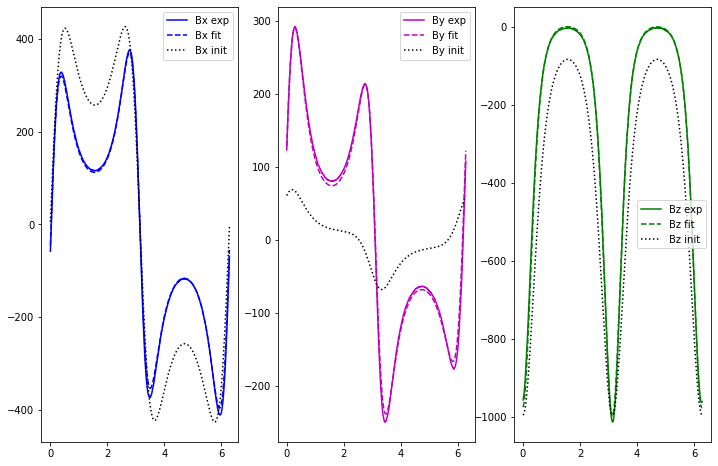

In [64]:
(a, b, theta, tiltRot0, dphi, offsetx, offsety, tiltAngle) = fitparams
(bx,by,bz) = ellipticalMagField(phi, a, b, theta, tiltRot0, 0, dphi, (offsetx, offsety), 0, fixedParams)

(a, b, theta, tiltRot0, dphi, offsetx, offsety, tiltAngle) = paramsinit
(bxi,byi,bzi) = ellipticalMagField(phi, a, b, theta, tiltRot0, 0, dphi, (offsetx, offsety), 0, fixedParams)


(bxe,bye, bze) = experiment.b[0]
phi = experiment.phi[0]
f,ax = plt.subplots(1, 3)

ax[0].plot(phi, bxe, 'b-', label = 'Bx exp')
ax[0].plot(phi, bx, 'b--', label = 'Bx fit')
ax[0].plot(phi, bxi, 'k:', label = 'Bx init')

ax[1].plot(phi, bye, 'm-', label = 'By exp')
ax[1].plot(phi, by, 'm--', label = 'By fit')
ax[1].plot(phi, byi, 'k:', label = 'By init')

ax[2].plot(phi, bze, 'g-', label = 'Bz exp');
ax[2].plot(phi, bz, 'g--', label = 'Bz fit')
ax[2].plot(phi, bzi, 'k:', label = 'Bz init')

ax[0].legend()
ax[1].legend()
ax[2].legend();

Looking at the residuals - the difference between the model and fit data can be revealing

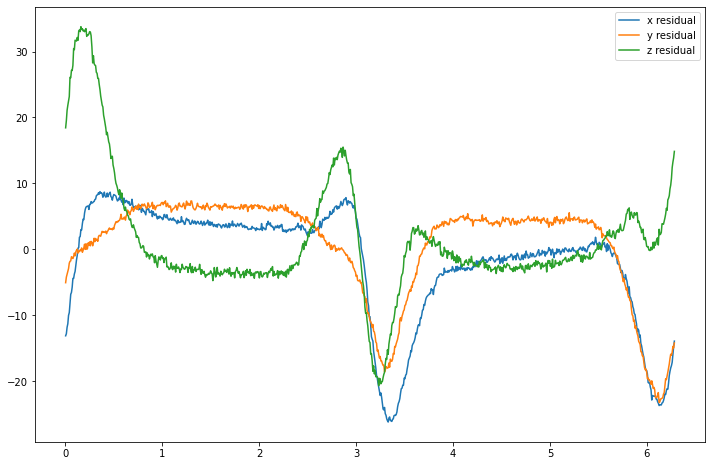

In [66]:
plt.plot(phi, bxe-bx, phi, bye-by, phi, bze-bz)
plt.legend(('x residual', 'y residual', 'z residual'))